# ETHZ: 227-0966-00L
# Quantitative Big Imaging
# April 12, 2018

## Complex Objects and Distributions

# Literature / Useful References

### Books
- Jean Claude, Morphometry with R
- [Online](http://link.springer.com/book/10.1007%2F978-0-387-77789-4) through ETHZ
- [Buy it](http://www.amazon.com/Morphometrics-R-Use-Julien-Claude/dp/038777789X)
- John C. Russ, “The Image Processing Handbook”,(Boca Raton, CRC Press)
- Available [online](http://dx.doi.org/10.1201/9780203881095) within domain ethz.ch (or proxy.ethz.ch / public VPN) 
- J. Weickert, Visualization and Processing of Tensor Fields
 - [Online](http://books.google.ch/books?id=ScLxPORMob4C&lpg=PA220&ots=mYIeQbaVXP&dq=&pg=PA220#v=onepage&q&f=false)


### Papers / Sites
- Voronoi Tesselations
 - Ghosh, S. (1997). Tessellation-based computational methods for the characterization and analysis of heterogeneous microstructures. Composites Science and Technology, 57(9-10), 1187–1210
 - [Wolfram Explanation](http://mathworld.wolfram.com/VoronoiDiagram.html)

- Self-Avoiding / Nearest Neighbor
 - Schwarz, H., & Exner, H. E. (1983). The characterization of the arrangement of feature centroids in planes and volumes. Journal of Microscopy, 129(2), 155–169.
 - Kubitscheck, U. et al. (1996). Single nuclear pores visualized by confocal microscopy and image processing. Biophysical Journal, 70(5), 2067–77.

- Alignment / Distribution Tensor
 - Mader, K. et al (2013). A quantitative framework for the 3D characterization of the osteocyte lacunar system. Bone, 57(1), 142–154
 - Aubouy, M., et al. (2003). A texture tensor to quantify deformations. Granular Matter, 5, 67–70. Retrieved from http://arxiv.org/abs/cond-mat/0301018
- Two point correlation
 - Dinis, L., et. al. (2007). Analysis of 3D solids using the natural neighbour radial point interpolation method. Computer Methods in Applied Mechanics and Engineering, 196(13-16)
 


In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams["figure.dpi"] = 150
plt.rcParams["font.size"] = 14
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
plt.style.use('ggplot')
sns.set_style("whitegrid", {'axes.grid': False})

# Previously on QBI ...


- Image Enhancment 
 - Highlighting the contrast of interest in images
 - Minimizing Noise
- Understanding image histograms
- Automatic Methods
- Component Labeling
- Single Shape Analysis
- Complicated Shapes (Thickness Maps)

# Outline

- Motivation (Why and How?)
- Skeletons
 - Tortuosity
- Watershed Segmentation
 - Connected Objects

*** 

### Local Environment
 - Neighbors
 - Voronoi Tesselation
 - Distribution Tensor
 
***

### Global Enviroment
 - Alignment
 - Self-Avoidance
 - Two Point Correlation Function

# Metrics

We examine a number of different metrics in this lecture and additionally to classifying them as Local and Global we can define them as point and voxel-based operations. 

### Point Operations
- Nearest Neighbor
- Delaunay Triangulation
  - Distribution Tensor
- Point (Center of Volume)-based Voronoi Tesselation
- Alignment

### Voxel Operation
- Voronoi Tesselation
- Neighbor Counting
- 2-point (N-point) correlation function

# Learning Objectives

### Motivation (Why and How?)

- How can we extract topology of a structure?
- How do we identify seperate objects when they are connected?
- How can we compare shape of complex objects when they grow?

Text(0.5,1,'Distance Map\nBackground')

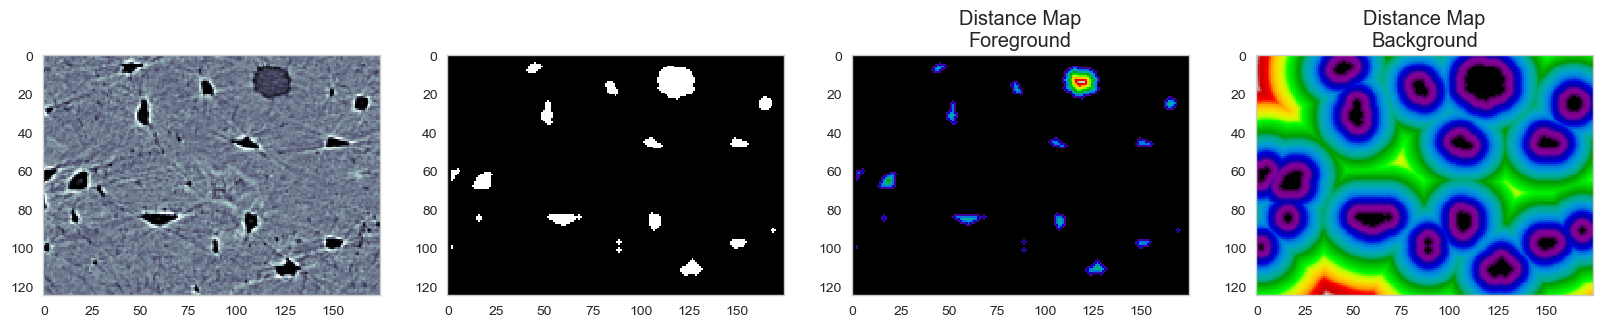

In [2]:
%matplotlib inline
from skimage.io import imread
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import distance_transform_edt
bw_img = imread("ext-figures/bonegfiltslice.png")[::2, ::2]
from skimage.morphology import binary_opening, binary_closing, disk
thresh_img = binary_closing(binary_opening(bw_img < 90, disk(1)), disk(2))
fg_dmap = distance_transform_edt(thresh_img)
bg_dmap = distance_transform_edt(1-thresh_img)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 6), dpi=100)
ax1.imshow(bw_img, cmap='bone')
ax2.imshow(thresh_img, cmap='bone')
ax3.set_title('Segmentation')
ax3.imshow(fg_dmap, cmap='nipy_spectral')
ax3.set_title('Distance Map\nForeground')
ax4.imshow(bg_dmap, cmap='nipy_spectral')
ax4.set_title('Distance Map\nBackground')

### Distribution Objectives
1. We want to know how many cells are alive
 - Maybe small cells are dead and larger cells are alive $\rightarrow$ examine the volume distribution
 - Maybe living cells are round and dead cells are really spiky and pointy $\rightarrow$ examine anisotropy

1. We want to know where the cells are alive or most densely packed
 - We can visually inspect the sample (maybe even color by volume)
 - We can examine the raw positions (x,y,z) but what does that really tell us?
 - We can make boxes and count the cells inside each one
 - How do we compare two regions in the same sample or even two samples?

# So what do we still need


1. A way for counting cells in a region and estimating density without creating arbitrary boxes
1. A way for finding out how many cells are _near_ a given cell, it's nearest neighbors
1. A way for quantifying how far apart cells are and then comparing different regions within a sample
1. A way for quantifying and comparing orientations



### What would be really great? 

A tool which could be adapted to answering a large variety of problems
- multiple types of structures
- multiple phases


Destructive Measurements
===
With most imaging techniques and sample types, the task of measurement itself impacts the sample.
- Even techniques like X-ray tomography which _claim_ to be non-destructive still impart significant to lethal doses of X-ray radition for high resolution imaging
- Electron microscopy, auto-tome-based methods, histology are all markedly more destructive and make longitudinal studies impossible
- Even when such measurements are possible
 - Registration can be a difficult task and introduce artifacts



### Why is this important?

- techniques which allow us to compare different samples of the same type.
- are sensitive to common transformations
 - Sample B after the treatment looks like Sample A stretched to be 2x larger
 - The volume fraction at the center is higher than the edges but organization remains the same


# Skeletonization / Networks


For some structures like cellular materials and trabecular bone, we want a more detailed analysis than just thickness. We want to know

- which structures are connected
- how they are connected
- express the network in a simple manner
 - quantify tortuosity
 - branching
 
We start with a simpler example from the EPFL Dataset: EPFL CVLab's Library of Tree-Reconstruction Examples (http://cvlab.epfl.ch/data/delin)

Text(0.5,1,'Roads')

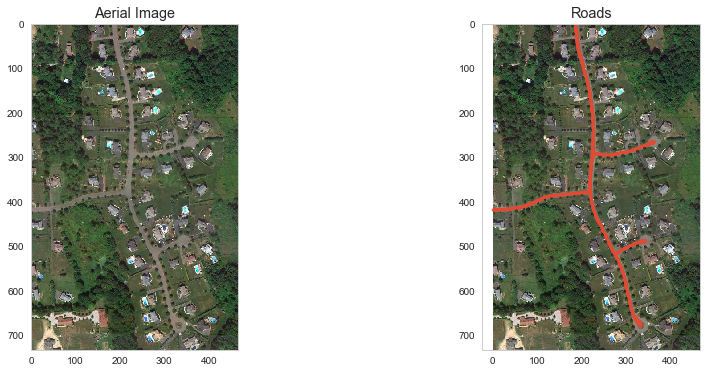

In [3]:
import matplotlib.pyplot as plt  # for showing plots
from skimage.io import imread  # for reading images
import numpy as np  # for matrix operations and array support
import pandas as pd  # for reading the swc files (tables of somesort)


def read_swc(in_path):
    swc_df = pd.read_csv(in_path, sep=' ', comment='#',
                         header=None)
    # a pure guess here
    swc_df.columns = ['id', 'junk1', 'x', 'y', 'junk2', 'width', 'next_idx']
    return swc_df[['x', 'y', 'width']]


im_data = imread('ext-figures/ny_7.tif')
mk_data = read_swc('ext-figures/ny_7.swc')

fig, (ax1, ax3) = plt.subplots(1, 2, figsize=(15, 6))
ax1.imshow(im_data)
ax1.set_title('Aerial Image')
ax3.imshow(im_data, cmap='bone')
ax3.scatter(mk_data['x'], mk_data['y'], s=mk_data['width'], alpha=0.5)
ax3.set_title('Roads')

Text(0.5,1,'Roads')

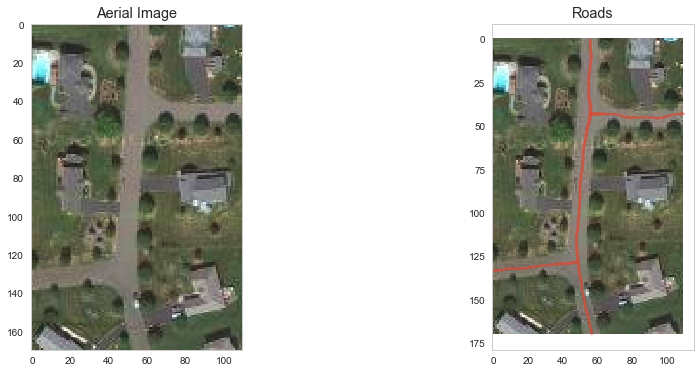

In [4]:
im_crop = im_data[250:420:1, 170:280:1]
mk_crop = mk_data.query('y>250').query(
    'y<420').query('x>170').query('x<280').copy()
mk_crop.x = (mk_crop.x-170)/1
mk_crop.y = (mk_crop.y-250)/1
fig, (ax1, ax3) = plt.subplots(1, 2, figsize=(15, 6))
ax1.imshow(im_crop)
ax1.set_title('Aerial Image')
ax3.imshow(im_crop, cmap='bone')
ax3.scatter(mk_crop['x'], mk_crop['y'], s=mk_crop['width'], alpha=0.25)
ax3.set_title('Roads');

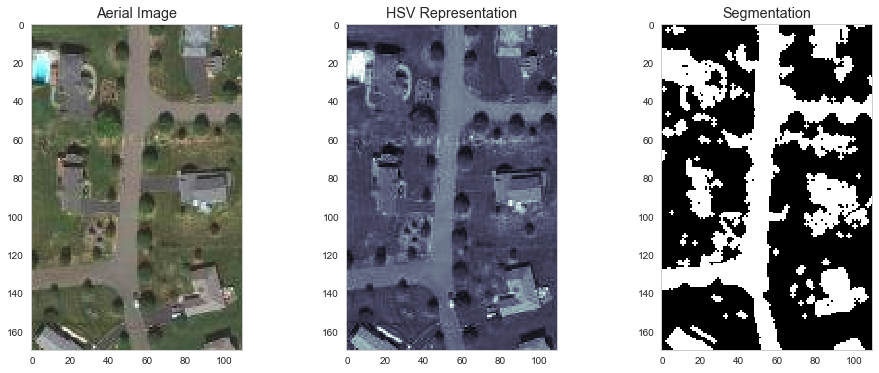

In [29]:
import seaborn as sns
from skimage.morphology import opening, closing, disk  # for removing small objects
from skimage.color import rgb2hsv
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 6))


def thresh_image(in_img):
    v_img = rgb2hsv(in_img)[:, :, 2]
    th_img = v_img > 0.4
    op_img = opening(th_img, disk(1))
    return op_img


ax1.imshow(im_crop)
ax1.set_title('Aerial Image')
ax2.imshow(rgb2hsv(im_crop)[:, :, 2],
           cmap='bone')
ax2.set_title('HSV Representation')
seg_img = thresh_image(im_crop)
ax3.imshow(seg_img, cmap='bone')
ax3.set_title('Segmentation');

Text(0.5,1,'Labels')

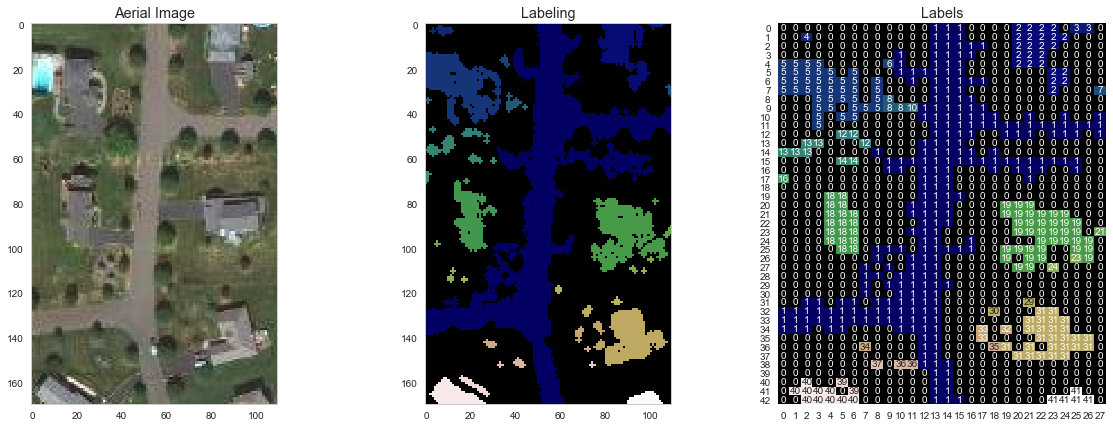

In [6]:
import seaborn as sns
from skimage.morphology import label
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 7))

ax1.imshow(im_crop)
ax1.set_title('Aerial Image')
lab_img = label(seg_img)
ax2.imshow(lab_img, cmap='gist_earth')
ax2.set_title('Labeling')

sns.heatmap(lab_img[::4, ::4],
            annot=True,
            fmt="d",
            cmap='gist_earth',
            ax=ax3,
            cbar=False,
            vmin=0,
            vmax=lab_img.max(),
            annot_kws={"size": 10})
ax3.set_title('Labels')

# Skeletonization

The first step is to take the distance transform the structure 
$$I_d(x,y) = \textrm{dist}(I(x,y))$$
We can see in this image there are already local maxima that form a sort of backbone which closely maps to what we are interested in.


Text(0.5,1,'Distance Map')

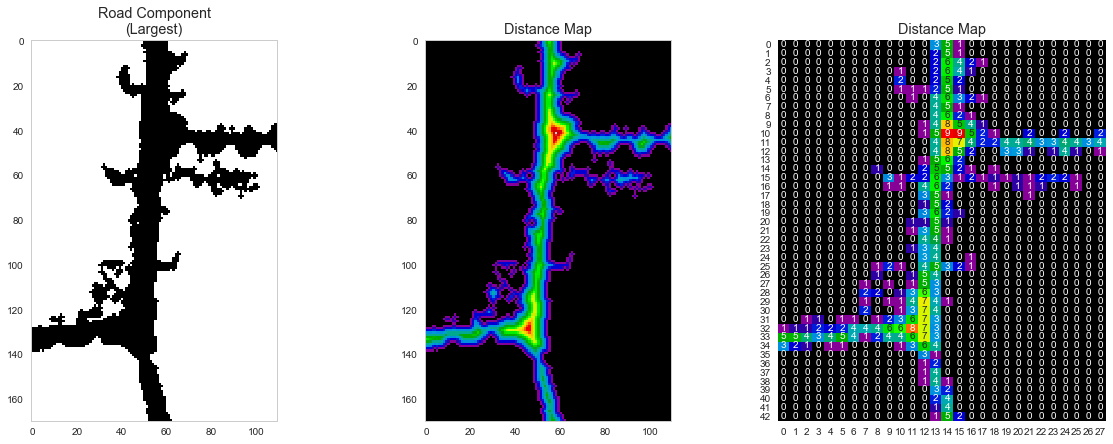

In [7]:
from scipy import ndimage
keep_lab_img = lab_img == 1
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 7))
ax1.imshow(keep_lab_img)
ax1.set_title('Road Component\n(Largest)')
dist_map = ndimage.distance_transform_edt(keep_lab_img)
ax2.imshow(dist_map, cmap='nipy_spectral')
ax2.set_title('Distance Map')

sns.heatmap(dist_map[::4, ::4],
            annot=True,
            fmt="1.0f",
            cmap='nipy_spectral',
            ax=ax3,
            cbar=False,
            vmin=0,
            vmax=dist_map.max(),
            annot_kws={"size": 10})
ax3.set_title('Distance Map')

# Skeletonization: Ridges

By using the laplacian filter as an approximate for the derivative operator which finds the values which high local gradients.

$$ \nabla I_{d}(x,y) = (\frac{\delta^2}{\delta x^2}+\frac{\delta^2}{\delta y^2})I_d \approx \underbrace{\begin{bmatrix}
-1 & -1 & -1 \\
-1 & 8 & -1 \\
-1 & -1 & -1
\end{bmatrix}}_{\textrm{Laplacian Kernel}} \otimes I_d(x,y) $$

## Creating the skeleton


We can locate the local maxima of the structure by setting a minimum surface distance
$$I_d(x,y)>MIN_{DIST}$$
and combining it with a minimum slope value 
$$\nabla I_d(x,y) > MIN_{SLOPE}$$

***

### Thresholds
Harking back to our earlier lectures, this can be seen as a threshold on a feature vector representation of the entire dataset.
- We first make the dataset into a tuple

$$ \textrm{cImg}(x,y) = \langle \underbrace{I_d(x,y)}_1, \underbrace{\nabla I_d(x,y)}_2 \rangle $$

$$ \textrm{skelImage}(x,y) = $$
$$ \begin{cases}
1, & \textrm{cImg}_1(x,y)\geq MIN-DIST \\ 
 &  \& \textrm{ cImg}_2(x,y)\geq MIN-SLOPE \\
0, & \textrm{otherwise}
\end{cases}$$ 


Text(0.5,1,'Distance Map Ridge')

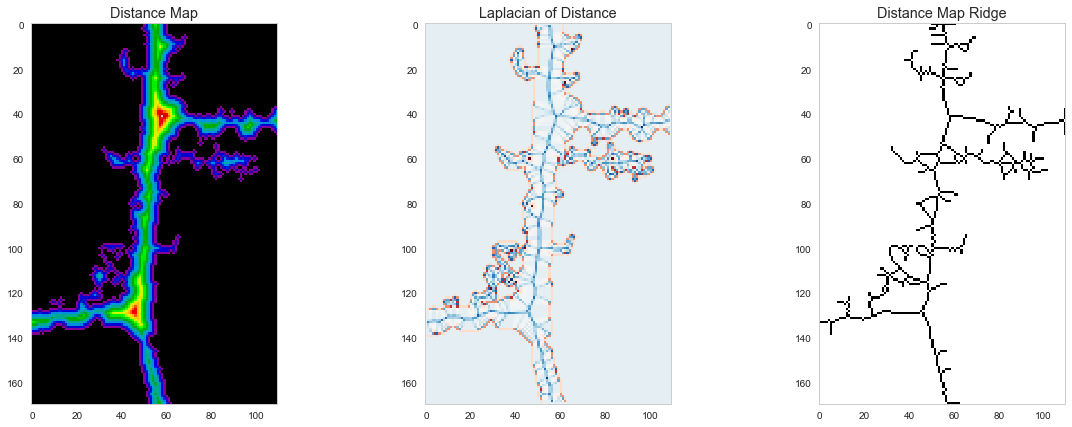

In [8]:
# for finding the medial axis and making skeletons
from skimage.morphology import medial_axis
# for just the skeleton code
from skimage.morphology import skeletonize, skeletonize_3d
from skimage.filters import laplace

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 7))

ax1.imshow(dist_map, cmap='nipy_spectral')
ax1.set_title('Distance Map')

ax2.imshow(laplace(dist_map), cmap='RdBu')
ax2.set_title('Laplacian of Distance')

# we use medial axis since it is cleaner
skel = medial_axis(keep_lab_img, return_distance=False)
ax3.imshow(skel)
ax3.set_title('Distance Map Ridge')

# Morphological thinning
From scikit-image documentation (http://scikit-image.org/docs/dev/auto_examples/edges/plot_skeleton.html)
```
Morphological thinning, implemented in the thin function, works on the same principle as skeletonize: remove pixels from the borders at each iteration until none can be removed without altering the connectivity. The different rules of removal can speed up skeletonization and result in different final skeletons.

The thin function also takes an optional max_iter keyword argument to limit the number of thinning iterations, and thus produce a relatively thicker skeleton.``` 

We can use this to thin the tiny junk elements first then erode, then perform the full skeletonization

Text(0.5,1,'Thinned/Opened Skeleton')

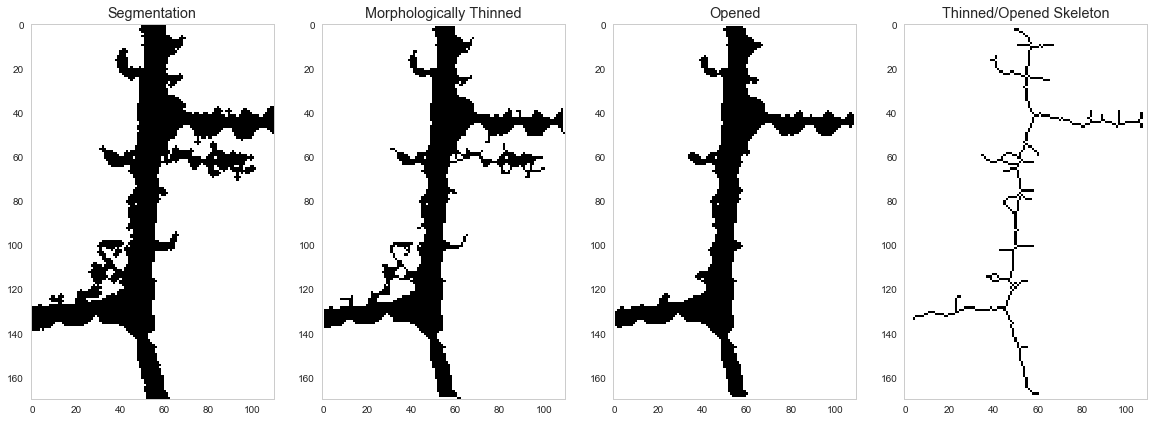

In [9]:
from skimage.morphology import thin, erosion
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 7))
ax1.imshow(keep_lab_img)
ax1.set_title('Segmentation')

thin_image = thin(keep_lab_img, max_iter=1)
ax2.imshow(thin_image)
ax2.set_title('Morphologically Thinned')

er_thin_image = opening(thin_image, disk(1))
er_thin_image = label(er_thin_image) == 1
ax3.imshow(er_thin_image)
ax3.set_title('Opened')

opened_skeleton = medial_axis(er_thin_image, return_distance=False)
ax4.imshow(opened_skeleton)
ax4.set_title('Thinned/Opened Skeleton')

### Still overgrown
The skeleton is still problematic for us and so we require some additional improvements to get a perfect skeleton

# Skeleton: Junction Overview 


With the skeleton which is ideally one voxel thick, we can characterize the junctions in the system by looking at the neighborhood of each voxel.


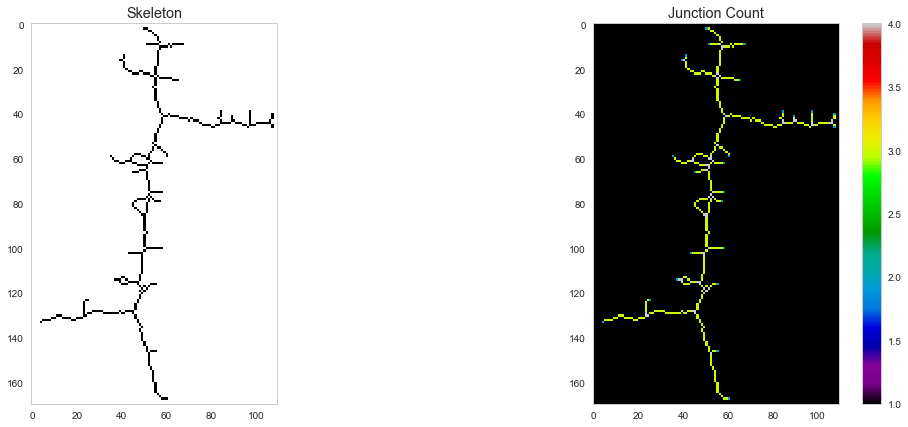

In [30]:
from scipy.ndimage import convolve

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
ax1.imshow(opened_skeleton)
ax1.set_title('Skeleton')
neighbor_conv = convolve(opened_skeleton.astype(int), np.ones((3, 3)))
neighbor_conv[~opened_skeleton] = 0
j_img = ax2.imshow(neighbor_conv,
                   cmap='nipy_spectral',
                   vmin=1, vmax=4,
                   interpolation='none')
plt.colorbar(j_img)
ax2.set_title('Junction Count');

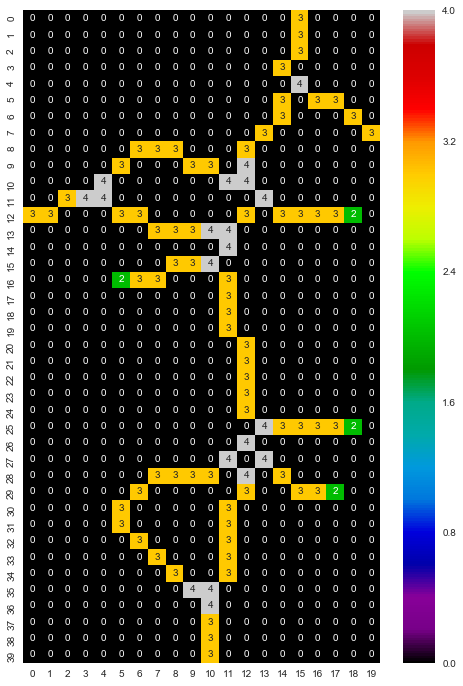

In [31]:
fig, ax1 = plt.subplots(1, 1, figsize=(8, 12))
n_crop = neighbor_conv[50:90, 40:60]
sns.heatmap(n_crop,
            annot=True,
            fmt="d",
            cmap='nipy_spectral',
            ax=ax1,
            cbar=True,
            vmin=0,
            vmax=n_crop.max(),
            annot_kws={"size": 10});

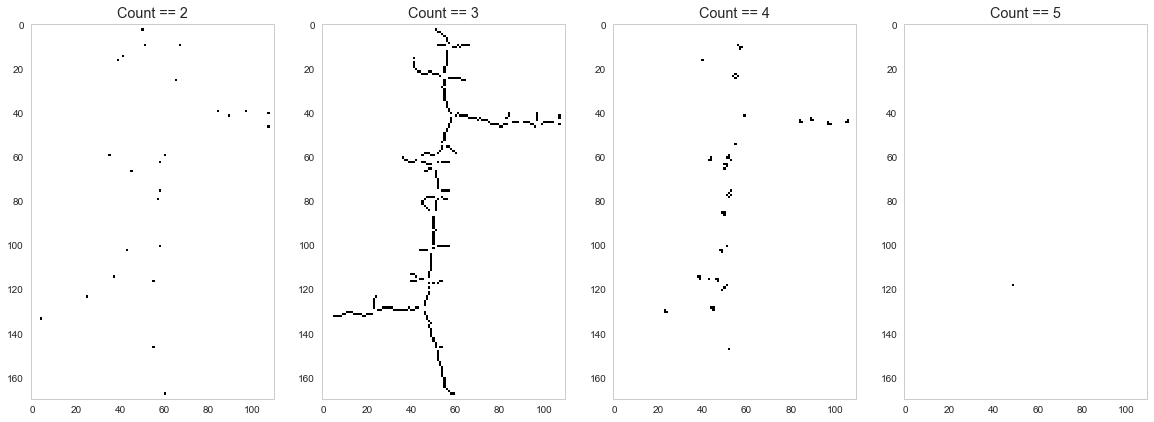

In [12]:
junc_types = np.unique(neighbor_conv[neighbor_conv > 0])
fig, m_axs = plt.subplots(1, len(junc_types), figsize=(20, 7))
for i, c_ax in zip(junc_types, m_axs):
    c_ax.imshow(neighbor_conv == i, interpolation='none')
    c_ax.set_title('Count == {}'.format(i))

## Dedicated pruning algorithms
 - Ideally model-based
 - Minimum branch length (using component labeling on the Count==3)
 - Minimum branch width (using the distance map values)
 

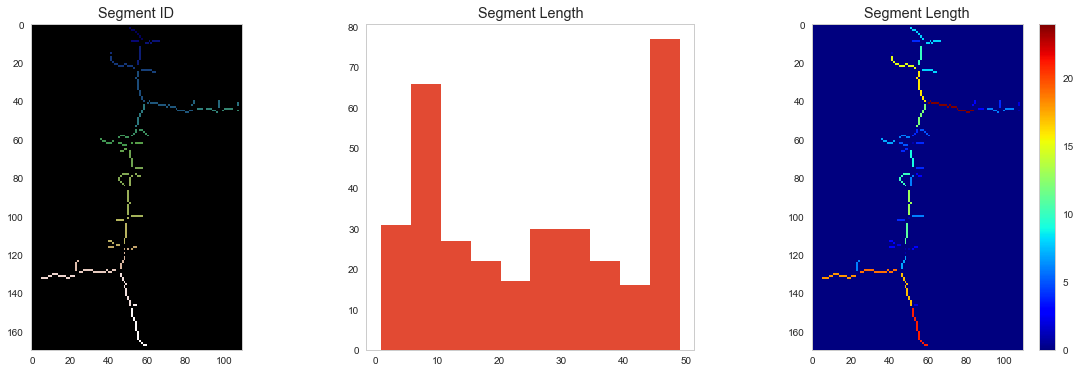

In [13]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
lab_seg = label(neighbor_conv == 3)
ax1.imshow(lab_seg, cmap='gist_earth')
ax1.set_title('Segment ID')
ax2.hist(lab_seg[lab_seg > 0])
ax2.set_title('Segment Length')

label_length_img = np.zeros_like(lab_seg)
for i in np.unique(lab_seg[lab_seg > 0]):
    label_length_img[lab_seg == i] = np.sum(lab_seg == i)

ll_ax = ax3.imshow(label_length_img, cmap='jet')
ax3.set_title('Segment Length')
plt.colorbar(ll_ax)

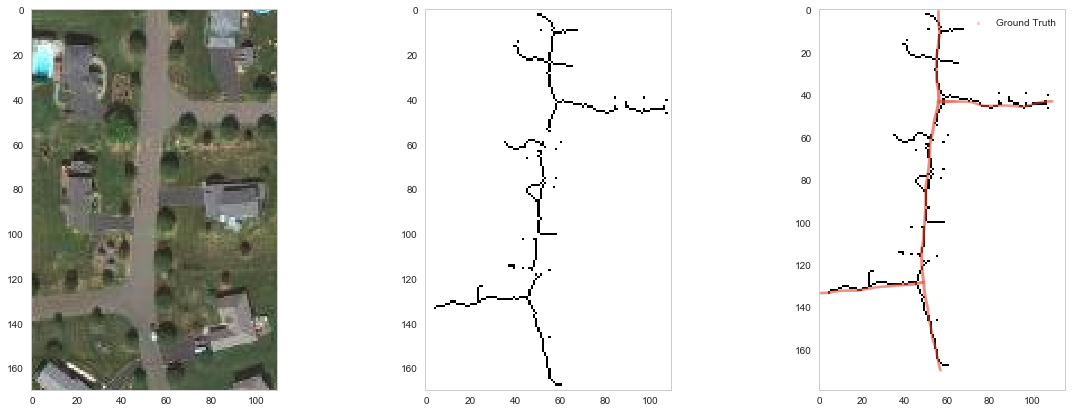

In [14]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 7))
length_skeleton = (label_length_img > 5) + \
    (neighbor_conv == 2)+(neighbor_conv > 3)
ax1.imshow(im_crop)
ax2.imshow(length_skeleton)
ax3.imshow(length_skeleton)
ax3.scatter(mk_crop['x'], mk_crop['y'], s=mk_crop['width'],
            alpha=0.25, label='Ground Truth')
ax3.legend()

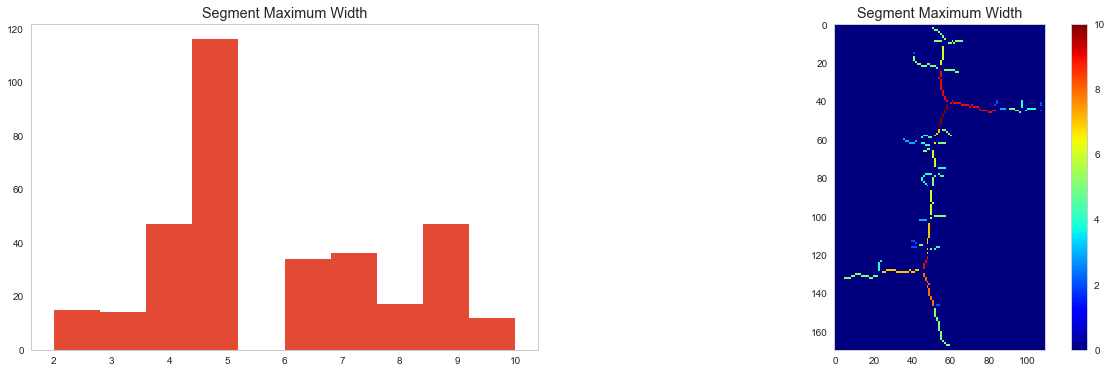

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

label_width_img = np.zeros_like(lab_seg)
for i in np.unique(lab_seg[lab_seg > 0]):
    label_width_img[lab_seg == i] = np.max(dist_map[lab_seg == i])

ax1.hist(label_width_img[label_width_img > 0])
ax1.set_title('Segment Maximum Width')


ll_ax = ax2.imshow(label_width_img, cmap='jet')
ax2.set_title('Segment Maximum Width')
plt.colorbar(ll_ax)

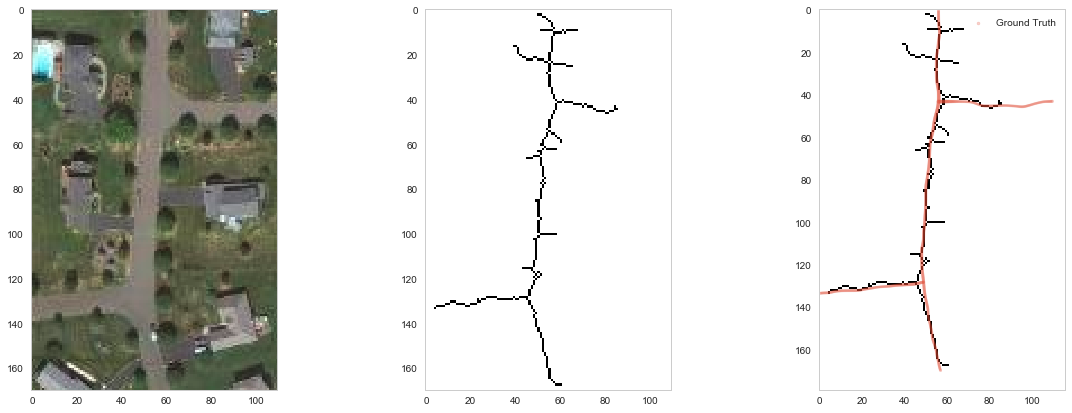

In [16]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 7))
width_skeleton = (label_width_img > 4.5) + \
    (neighbor_conv == 2)+(neighbor_conv > 3)
width_skeleton = label(width_skeleton) == 1
ax1.imshow(im_crop)
ax2.imshow(width_skeleton)
ax3.imshow(width_skeleton)
ax3.scatter(mk_crop['x'], mk_crop['y'], s=mk_crop['width'],
            alpha=0.25, label='Ground Truth')
ax3.legend()

# Establish Topology
From the cleaned, pruned skeleton we can start to establish topology. Using the same criteria as before we can break down the image into segments, junctions, and end-points

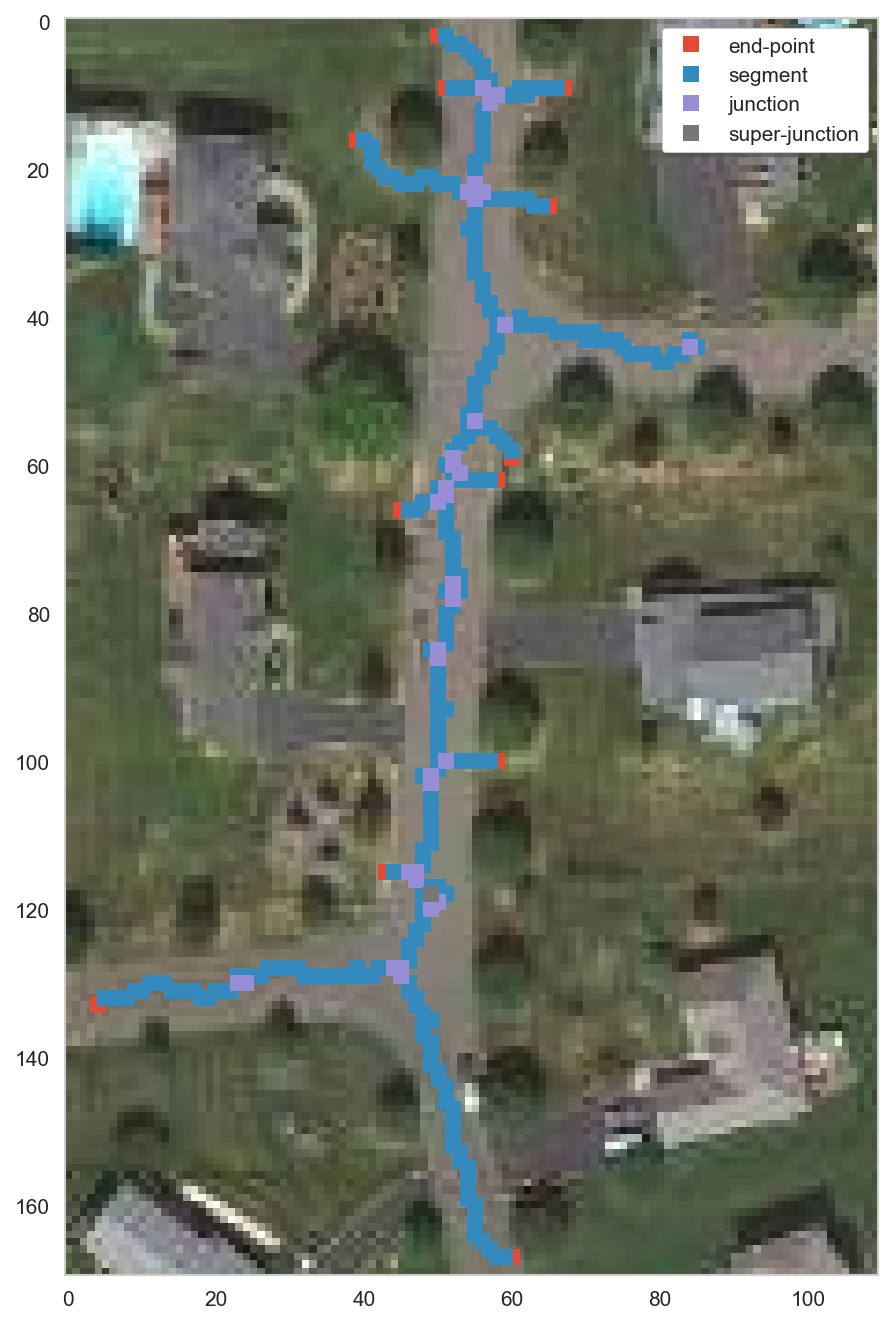

In [17]:
ws_neighbors = convolve(width_skeleton.astype(int), np.ones((3, 3)), mode = 'constant', cval = 0)
ws_neighbors[~width_skeleton] = 0
fig, (ax1) = plt.subplots(1, 1, figsize=(7, 12), dpi=150)
ax1.imshow(im_crop)
j_name = {1: 'dangling point', 2: 'end-point', 3: 'segment', 4: 'junction', 5: 'super-junction'}
for j_count in np.unique(ws_neighbors[ws_neighbors>0]):
    y_c, x_c = np.where(ws_neighbors == j_count)
    ax1.plot(x_c, y_c, 's', 
             label=j_name.get(j_count, 'unknown'), 
             markersize=8)

leg = ax1.legend(shadow = True, fancybox = True, frameon = True)

# Getting Topology in Image Space
We want to determine which nodes are directly connected in this image so we can extract a graph. If we take a simple case of two nodes connected by one edge and the bottom node connected to another edge going nowhere.

$$ \begin{bmatrix}
n & 0 & 0 & 0 \\
0 & e & 0 & 0 \\
0 & 0 & n & e
\end{bmatrix} $$

We can use component labeling to identify each node and each edge uniquely
## Node Labels

$$ N_{lab} = \begin{bmatrix}
1 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 \\
0 & 0 & 2 & 0
\end{bmatrix} $$

## Edge Labels

$$E_{lab} = \begin{bmatrix}
0 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 0 & 2
\end{bmatrix} $$

We can then use a dilation operation on the nodes and the edges to see which overlap

Text(0.5,1,'Grow Second\nEdges Found: [1, 2]')

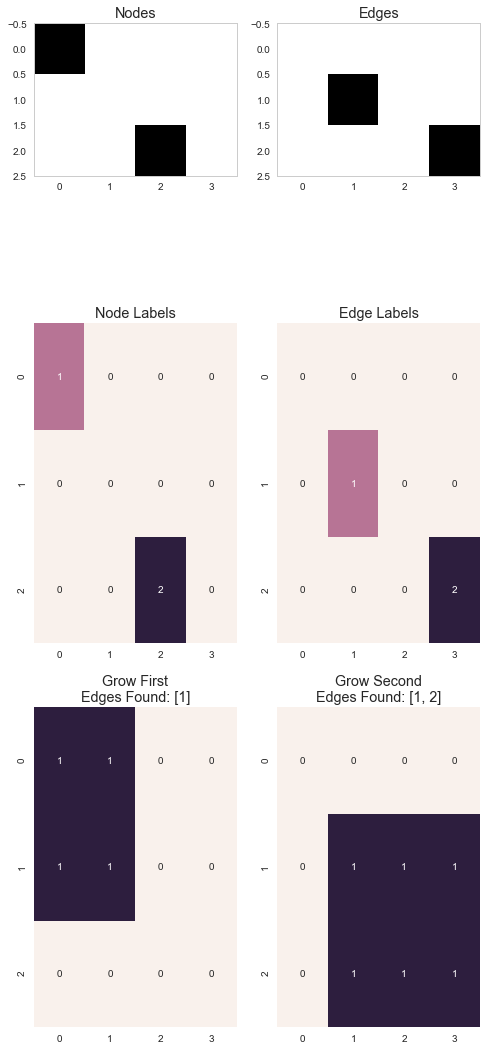

In [18]:
from skimage.morphology import dilation
n_img = np.zeros((3, 4))
e_img = np.zeros_like(n_img)
n_img[0,0] = 1
e_img[1,1] = 1
n_img[2,2] = 1
e_img[2,3] = 1


fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(8, 20))

ax1.imshow(n_img)
ax1.set_title('Nodes')

ax2.imshow(e_img)
ax2.set_title('Edges')

# labeling
n_labs = label(n_img)

sns.heatmap(n_labs, annot=True, fmt="d",ax = ax3, cbar = False)
ax3.set_title('Node Labels')

e_labs = label(e_img)

sns.heatmap(e_labs, annot=True, fmt="d",ax = ax4, cbar = False)
ax4.set_title('Edge Labels')

# growing
n_grow_1 = dilation(n_labs==1, np.ones((3,3)))

sns.heatmap(n_grow_1, annot=True, fmt="d",ax = ax5, cbar = False)
ax5.set_title('Grow First\n{} {}'.format('Edges Found:', [x for x in np.unique(e_labs[n_grow_1>0]) if x>0]))

n_grow_2 = dilation(n_labs==2, np.ones((3,3)))
sns.heatmap(n_grow_2, annot=True, fmt="d",ax = ax6, cbar = False)
ax6.set_title('Grow Second\n{} {}'.format('Edges Found:', [x for x in np.unique(e_labs[n_grow_2>0]) if x>0]))


Edge 1 connects [1, 3]
Edge 2 connects [2, 3]
Edge 3 connects [3, 4]
Edge 4 connects [3, 6]
Edge 5 connects [5, 6]
Edge 6 connects [6, 7]
Edge 7 connects [6, 8]
Edge 8 connects [8, 9]
Edge 9 connects [8, 10]
Edge 10 connects [9]
Edge 11 connects [10, 11]
Edge 12 connects [10, 12]
Edge 13 connects [11]
Edge 14 connects [11, 14]
Edge 15 connects [11, 13]
Edge 16 connects [14]
Edge 17 connects [14, 15]
Edge 18 connects [14, 16]
Edge 19 connects [16, 17]
Edge 20 connects [16, 17]
Edge 21 connects [17, 18]
Edge 22 connects [18]
Edge 23 connects [18, 19]
Edge 24 connects [19, 20]
Edge 25 connects [19, 21]
Edge 26 connects [21]
Edge 27 connects [21, 23]
Edge 28 connects [22, 23]
Edge 29 connects [23, 24]
Edge 30 connects [24]
Edge 31 connects [24]
Edge 32 connects [24, 25]
Edge 33 connects [25, 26]
Edge 34 connects [26]
Edge 35 connects [26, 27]
Edge 36 connects [25, 28]


Text(0.5,1.05,'Connectivity Matrix')

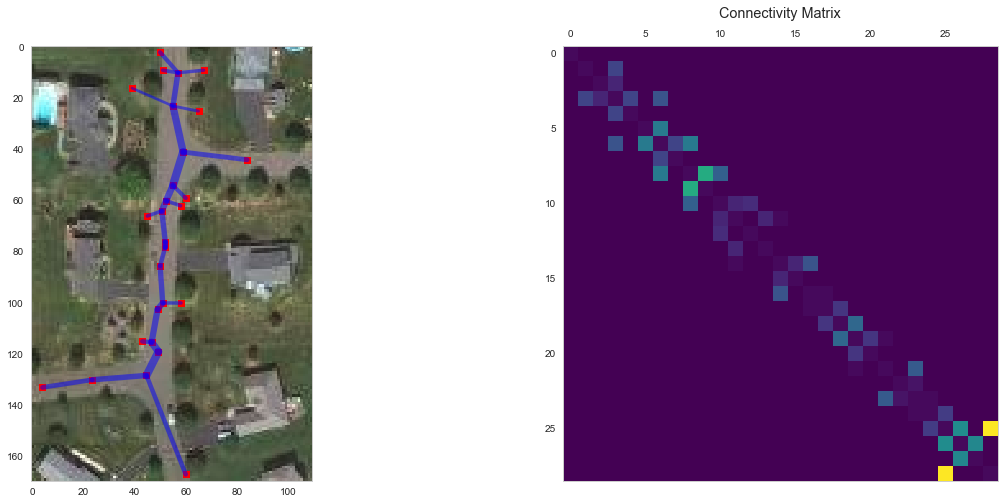

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
node_id_image = label((ws_neighbors > 3) | (ws_neighbors==2))
edge_id_image = label(ws_neighbors==3)

ax1.imshow(im_crop)

node_dict = {}
for c_node in np.unique(node_id_image[node_id_image>0]):
    y_n, x_n = np.where(node_id_image==c_node)
    node_dict[c_node] = {'x': np.mean(x_n),
                        'y': np.mean(y_n),
                        'width': np.mean(dist_map[node_id_image==c_node])}
    ax1.plot(np.mean(x_n), np.mean(y_n), 'rs')

edge_dict = {}
edge_matrix = np.eye(len(node_dict)+1)
for c_edge in np.unique(edge_id_image[edge_id_image>0]):
    edge_grow_mask = dilation(edge_id_image==c_edge, np.ones((3,3)))
    v_nodes = np.unique(node_id_image[edge_grow_mask>0])
    v_nodes = [v for v in v_nodes if v>0]
    print('Edge', c_edge, 'connects', v_nodes)
    if len(v_nodes)==2:
        edge_dict[c_edge] = {'start': v_nodes[0], 
                             'end': v_nodes[-1],
                            'length': np.sum(edge_id_image==c_edge),
                            'max_width': np.max(dist_map[edge_id_image==c_edge]),
                            'mean_width': np.mean(dist_map[edge_id_image==c_edge])}
        edge_matrix[v_nodes[0], v_nodes[-1]] = np.sum(edge_id_image==c_edge)
        edge_matrix[v_nodes[-1], v_nodes[0]] = np.sum(edge_id_image==c_edge)
        s_node = node_dict[v_nodes[0]]
        e_node = node_dict[v_nodes[-1]]
        ax1.plot([s_node['x'], e_node['x']], 
                 [s_node['y'], e_node['y']], 'b-', linewidth = np.mean(dist_map[edge_id_image==c_edge]), alpha = 0.5)

ax2.matshow(edge_matrix, cmap = 'viridis')
ax2.set_title('Connectivity Matrix')

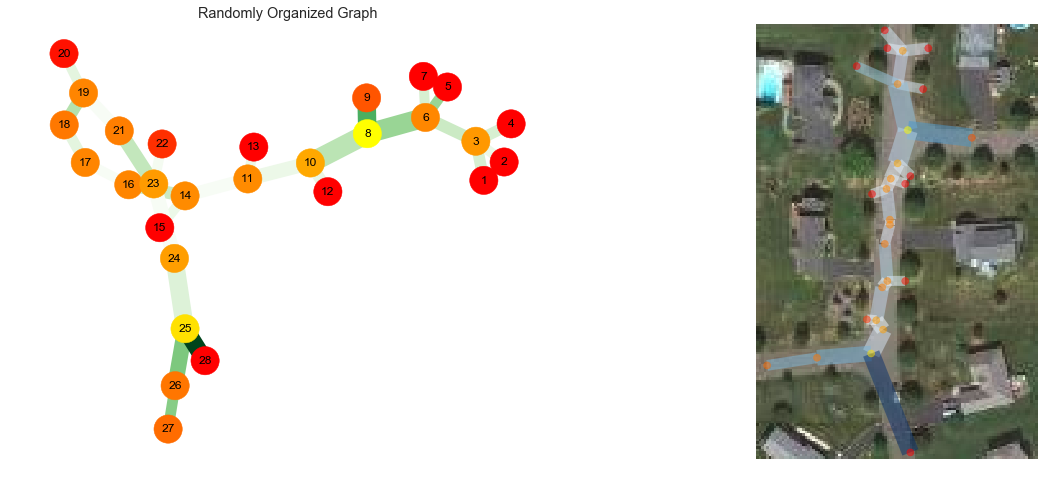

In [20]:
import networkx as nx
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
G = nx.Graph()
for k, v in node_dict.items():
    G.add_node(k, weight=v['width'])
for k, v in edge_dict.items():
    G.add_edge(v['start'], v['end'], **v)
nx.draw_spring(G, ax=ax1, with_labels=True,
               node_color=[node_dict[k]['width'] for k in sorted(node_dict.keys())],
               node_size=800,
               cmap=plt.cm.autumn,
              edge_color=[G.edges[k]['length'] for k in list(G.edges.keys())],
        width=[2*G.edges[k]['max_width'] for k in list(G.edges.keys())],
              edge_cmap = plt.cm.Greens)
ax1.set_title('Randomly Organized Graph')
ax2.imshow(im_crop)
nx.draw(G,
        pos={k: (v['x'], v['y']) for k, v in node_dict.items()},
        ax=ax2,
        node_color=[node_dict[k]['width'] for k in sorted(node_dict.keys())],
        node_size=50,
        cmap=plt.cm.autumn,
       edge_color=[G.edges[k]['length'] for k in list(G.edges.keys())],
        width=[2*G.edges[k]['max_width'] for k in list(G.edges.keys())], 
        edge_cmap=plt.cm.Blues, 
        alpha = 0.5,
        with_labels=False)

## Graph Analysis
Once the data has been represented in a graph form, we can begin to analyze some of graph aspects of it, like the degree and connectivity plots.

(array([ 0., 13.,  6.,  7.,  2.,  0.,  0.,  0.,  0.]),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 9 Patch objects>)

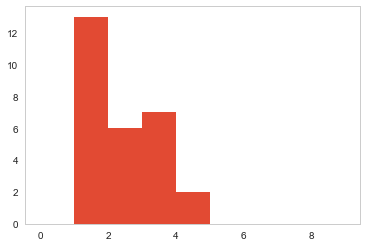

In [21]:
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)  # degree sequence
plt.hist(degree_sequence, bins = np.arange(10))

# Watershed


Watershed is a method for segmenting objects without using component labeling. 
- It utilizes the shape of structures to find objects
- From the distance map we can make out substructures with our eyes
- But how to we find them?!

We use a sample image now from the [Datascience Bowl 2018 from Kaggle](https://www.kaggle.com/c/data-science-bowl-2018). The challenge is to identify nuclei in histology images to eventually find cancer better. The winner tweeted about the solution [here](https://twitter.com/alxndrkalinin/status/986260848376197120)

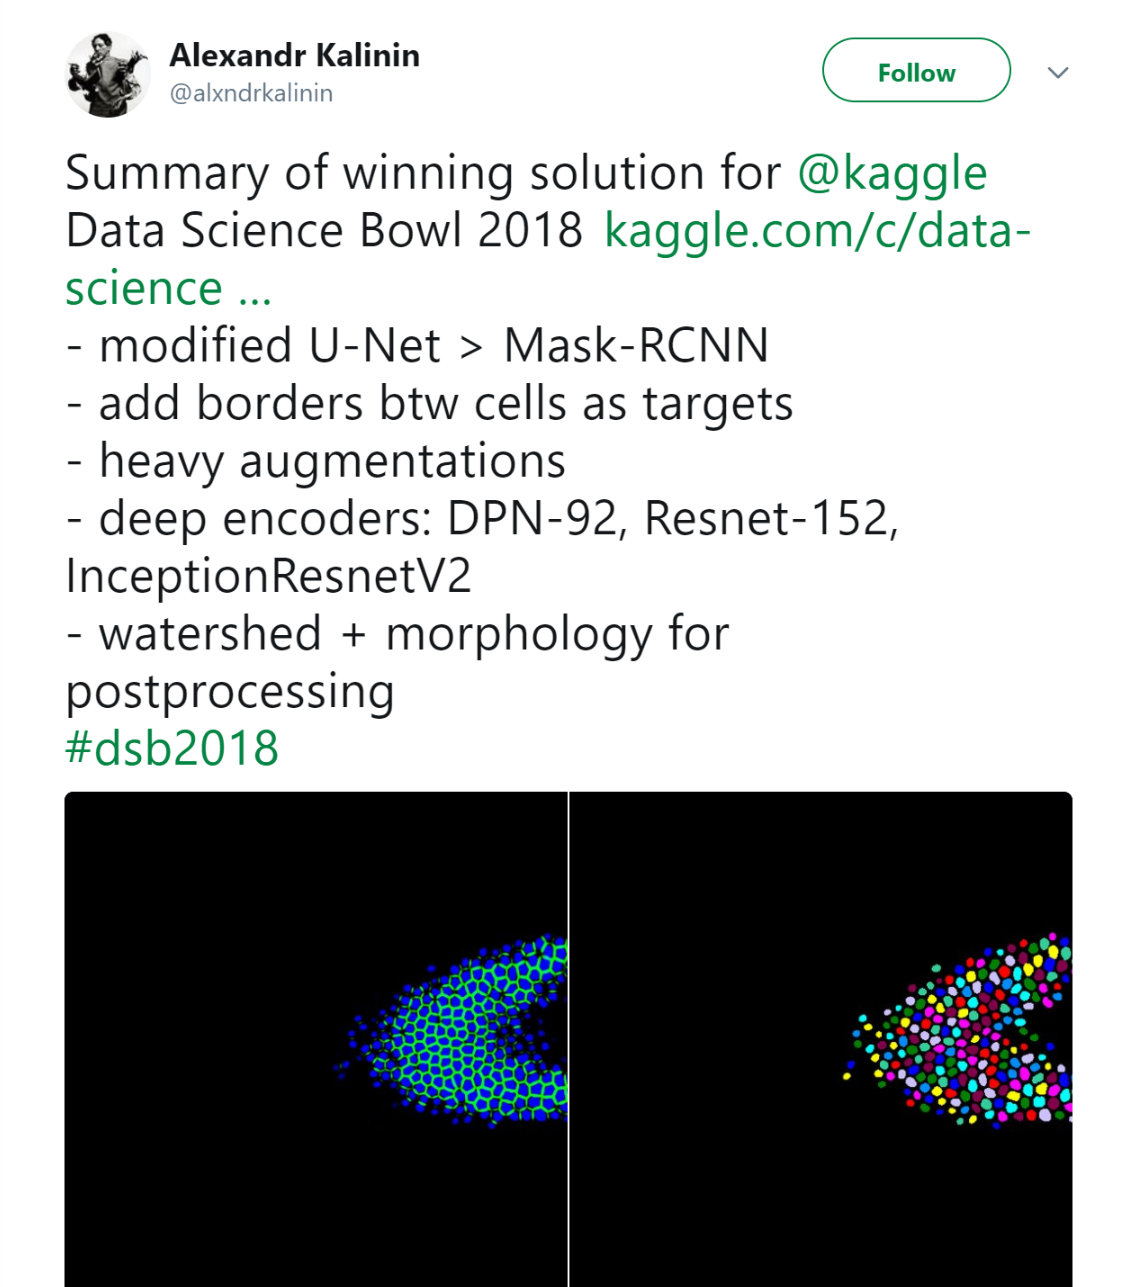

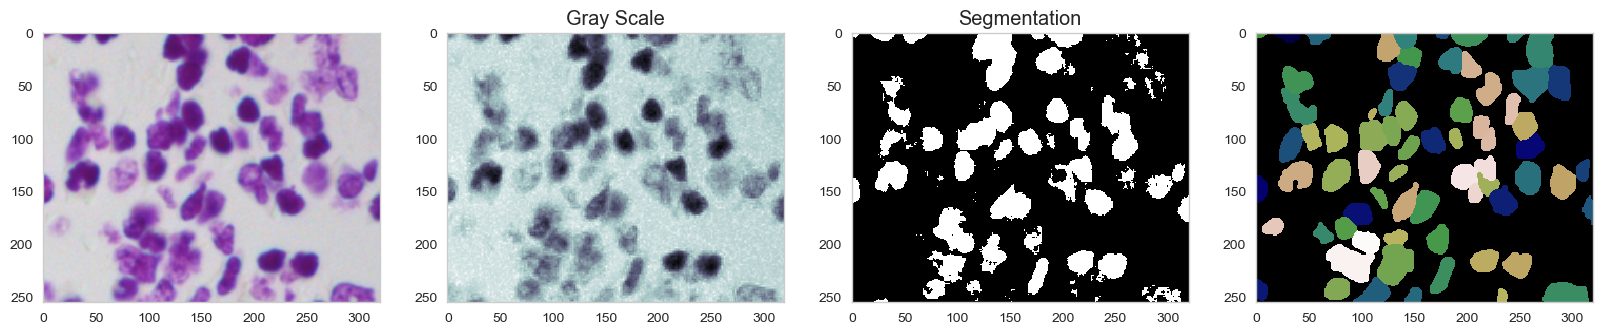

In [22]:
%matplotlib inline
from skimage.io import imread
import matplotlib.pyplot as plt
import numpy as np

from skimage.color import rgb2hsv
from skimage.filters import threshold_otsu
rgb_img = imread("../common/figures/dsb_sample/slide.png")[:,:,:3]
gt_labs = imread("../common/figures/dsb_sample/labels.png")
bw_img = rgb2hsv(rgb_img)[:,:,2]

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 6), dpi=100)
ax1.imshow(rgb_img, cmap='bone')
ax2.imshow(bw_img, cmap='bone')
ax2.set_title('Gray Scale')
ax3.imshow(bw_img<threshold_otsu(bw_img), cmap = 'bone')
ax3.set_title('Segmentation')
ax4.imshow(gt_labs, cmap = 'gist_earth')

Text(0.5,1,'Ground Truth')

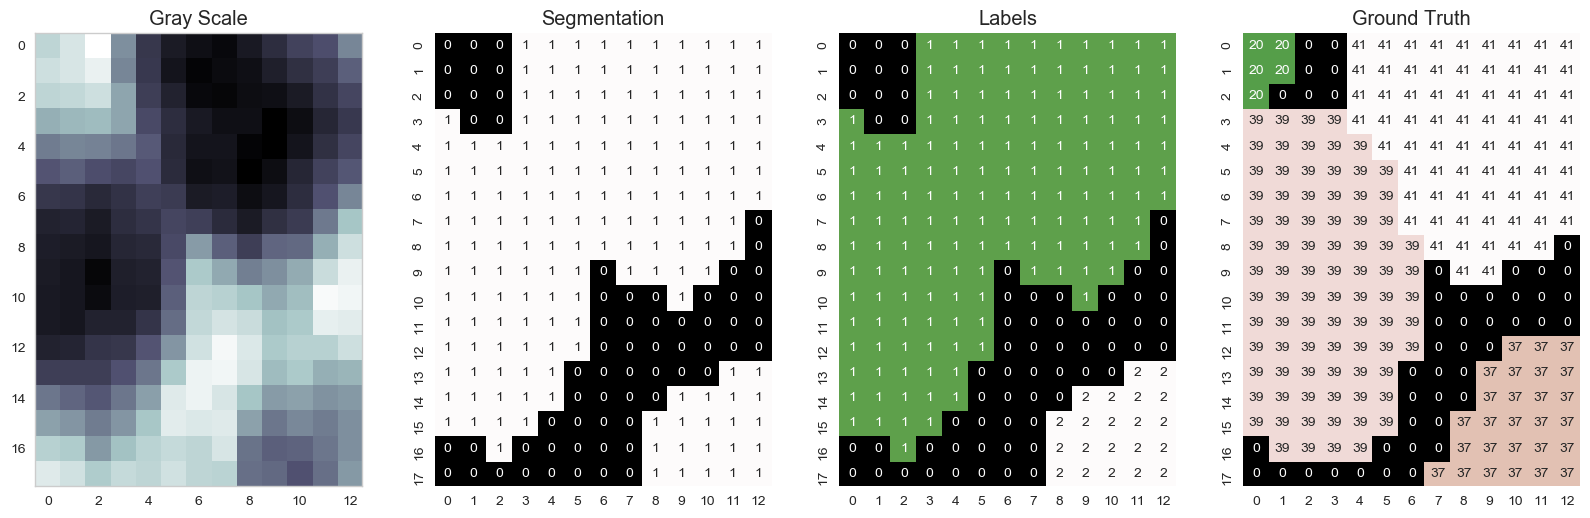

In [23]:
from skimage.morphology import label
import seaborn as sns
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 6), dpi=100)
bw_roi = bw_img[75:110:2, 125:150:2]
ax1.imshow(bw_roi, cmap='bone')
ax1.set_title('Gray Scale')
bw_roi_seg = bw_roi<threshold_otsu(bw_img)
sns.heatmap(bw_roi_seg, annot=True, fmt="d", ax = ax2, cbar = False, cmap = 'gist_earth')
ax2.set_title('Segmentation')
bw_roi_label = label(bw_roi_seg)
sns.heatmap(bw_roi_label, annot=True, fmt="d", ax = ax3, cbar = False, cmap = 'gist_earth')
ax3.set_title('Labels')
sns.heatmap(gt_labs[75:110:2, 125:150:2], annot=True, fmt="d", ax = ax4, cbar = False, cmap = 'gist_earth')
ax4.set_title('Ground Truth')

# Watershed: Flowing Downhill


We can imagine watershed as waterflowing down hill into basins. The topology in this case is given by the distance map

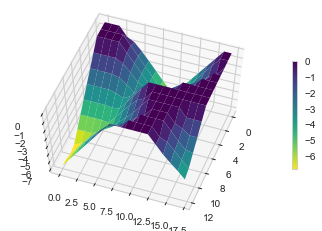

In [24]:
from scipy.ndimage import distance_transform_edt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.gca(projection='3d')
bw_roi_dmap = distance_transform_edt(bw_roi_seg)

# Plot the surface.
t_xx, t_yy = np.meshgrid(np.arange(bw_roi_dmap.shape[1]),
                       np.arange(bw_roi_dmap.shape[0]))
surf = ax.plot_surface(t_xx, t_yy,
                       -1*bw_roi_dmap, 
                       cmap=plt.cm.viridis_r,
                       linewidth=0.1, 
                       antialiased=True)

# Customize the z axis.
ax.view_init(60, 20)
# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5);

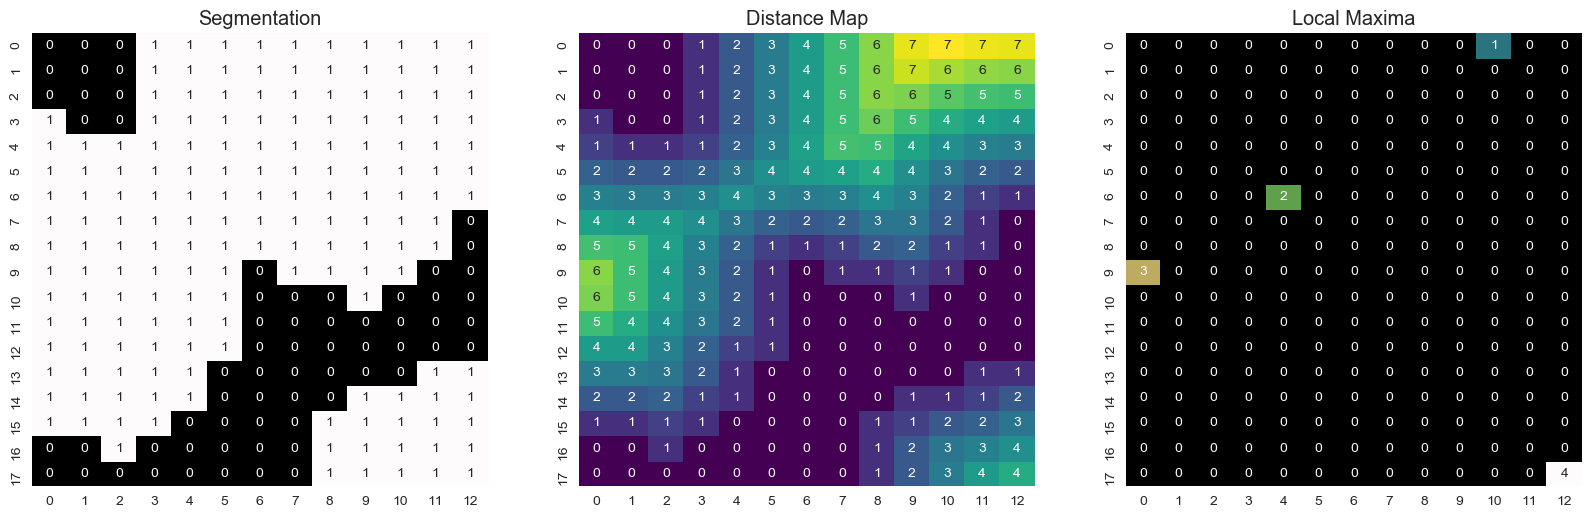

In [25]:
from skimage.feature import peak_local_max
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6), dpi=100)
sns.heatmap(bw_roi_seg, annot=True, fmt="d", ax = ax1, cbar = False, cmap = 'gist_earth')
ax1.set_title('Segmentation')
sns.heatmap(bw_roi_dmap, annot=True, fmt="1.0f", ax = ax2, cbar = False, cmap = 'viridis')
ax2.set_title('Distance Map')
roi_local_maxi = peak_local_max(bw_roi_dmap, indices=False, footprint=np.ones((3, 3)),
                            labels=bw_roi_seg, exclude_border = False)
labeled_maxi = label(roi_local_maxi)

sns.heatmap(labeled_maxi, annot=True, fmt="1.0f", ax = ax3, cbar = False, cmap = 'gist_earth')
ax3.set_title('Local Maxima');

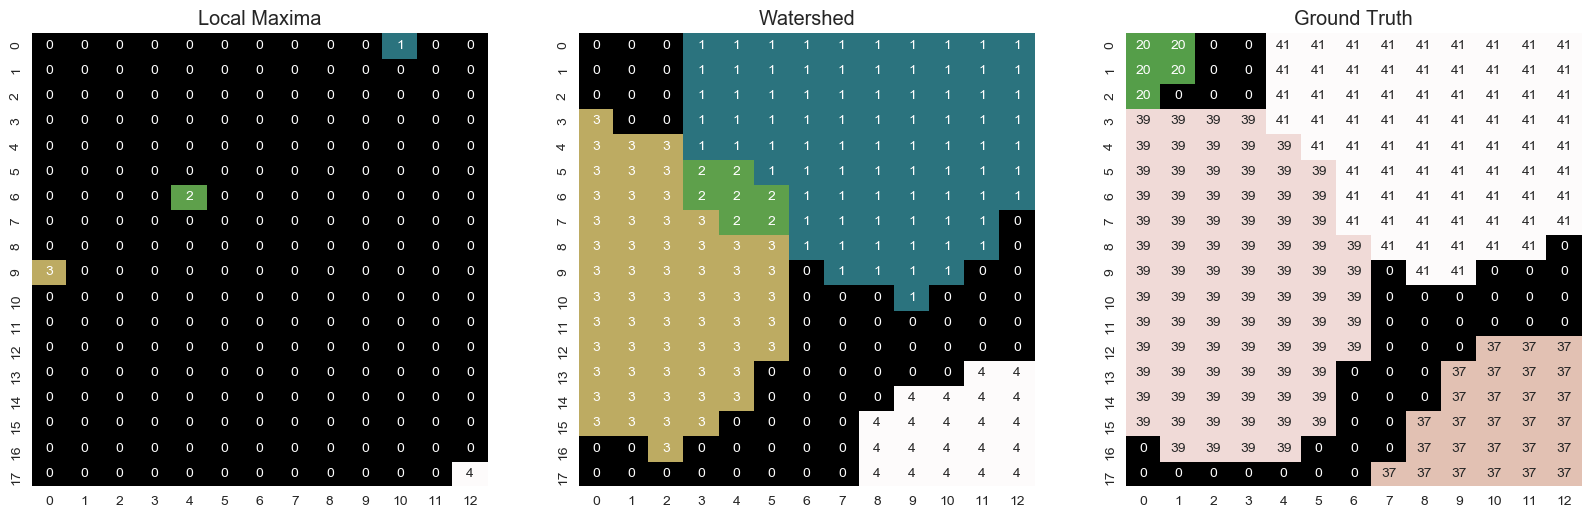

In [26]:
from skimage.morphology import watershed
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6), dpi=100)
sns.heatmap(labeled_maxi, annot=True, fmt="1.0f", ax = ax1, cbar = False, cmap = 'gist_earth')
ax1.set_title('Local Maxima');

ws_labels = watershed(-bw_roi_dmap, labeled_maxi, mask=bw_roi_seg)

sns.heatmap(ws_labels, annot=True, fmt="d", ax = ax2, cbar = False, cmap = 'gist_earth')
ax2.set_title('Watershed')

sns.heatmap(gt_labs[75:110:2, 125:150:2], annot=True, fmt="d", ax = ax3, cbar = False, cmap = 'gist_earth')
ax3.set_title('Ground Truth');

# Scaling back up
Now we can perform the operation on the whole image and see how the results look


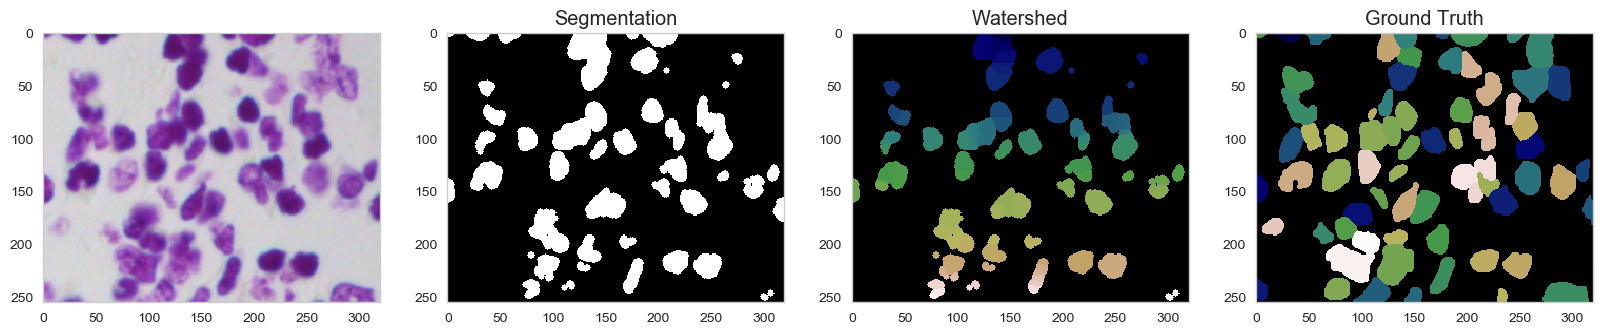

In [27]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 6), dpi=100)
ax1.imshow(rgb_img, cmap='bone')

from skimage.morphology import opening, disk
bw_seg_img = opening(bw_img<threshold_otsu(bw_img), disk(3))

ax2.imshow(bw_seg_img, cmap = 'bone')
ax2.set_title('Segmentation')

bw_dmap = distance_transform_edt(bw_seg_img)
bw_peaks = label(peak_local_max(bw_dmap, indices=False, footprint=np.ones((3, 3)),
                            labels=bw_seg_img, exclude_border = True))

ws_labels = watershed(-bw_dmap, bw_peaks, mask=bw_seg_img)

ax3.imshow(ws_labels, cmap = 'gist_earth')
ax3.set_title('Watershed')

ax4.imshow(gt_labs, cmap = 'gist_earth')
ax4.set_title('Ground Truth');